<a href="https://colab.research.google.com/github/Eugenia27/AnalisisSeriesTemporales/blob/master/practico1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRACTICO 1: SERIRES TEMPORALES
AUTORAS: Nair Trógolo y María Eugenia Ferraro


In [0]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [0]:
""" Plotting methods for temp series """

__author__ = "Marcel Scharth"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_components_x13(results, label=''):
    colours=['#D62728', '#FF7F0E', '#2CA02C', '#1F77B4']
    fig, ax = plt.subplots(2,2, figsize=(12,8))
    ax[0,0].plot(results.observed, color=colours[0], alpha=0.95)
    ax[0,0].set(ylabel=label, title='Observed')
    ax[0,1].plot(results.trend, color=colours[1], alpha=0.95)
    ax[0,1].set(title='Trend')
    ax[1,0].plot(results.observed/results.seasadj, color=colours[2],  alpha=0.95)
    ax[1,0].set(ylabel=label, title='Seasonal')
    ax[1,1].plot(results.irregular, color=colours[3],  alpha=0.95)
    ax[1,1].set(title='Irregular')
    sns.despine()
    fig.suptitle('Time series decomposition  (X-13 ARIMA-SEATS)', fontsize=13.5)   
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax

def fanchart(y, forecast, intv1, intv2, intv3,color):
    assert type(y)==pd.core.series.Series, 'The time series must be a pandas series'
    assert type(forecast)==pd.core.series.Series, 'The forecast must be a pandas series'

    last=y.iloc[-1:]
    extended=last.append(forecast)

    with sns.axes_style('ticks'):
        fig, ax = plt.subplots(figsize=(8,5))
        y.plot(color=color,marker='o',alpha=0.7)
        extended.plot(color='black', alpha=0.4, label='Point forecast')
        ax.fill_between(extended.index, last.append(intv3.iloc[:,0]), last.append(intv3.iloc[:,1]),
                        facecolor=color, lw=0, alpha=0.3)
        ax.fill_between(extended.index, last.append(intv2.iloc[:,0]), last.append(intv2.iloc[:,1]),
                        facecolor=color, lw=0, alpha=0.3)
        ax.fill_between(extended.index, last.append(intv1.iloc[:,0]), last.append(intv1.iloc[:,1]),
                        facecolor=color, lw=0, alpha=0.3)
        hold = ax.get_ylim()
        ax.fill_betweenx(ax.get_ylim(), extended.index[0], extended.index[-1], facecolor='grey', alpha=0.15)
        ax.set_ylim(hold)
    return fig, ax

def histogram(series):
    fig, ax= plt.subplots(figsize=(8,5))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': '#1F77B4'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

def qq_plot(residuals):
    fig, ax = plt.subplots(figsize=(8,5))
    pp = sm.ProbPlot(residuals, fit=True)
    qq = pp.qqplot(color='#1F77B4', alpha=0.8, ax=ax)
    a=ax.get_xlim()[0]
    b=ax.get_xlim()[1]
    ax.plot([a,b],[a,b], color='black', alpha=0.6)
    ax.set_xlim(a,b)
    ax.set_title('Normal Q-Q plot for the residuals', fontsize=12)
    return fig, ax

In [0]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks')
%matplotlib inline

In [0]:
plt.rcParams['figure.figsize'] = [15, 5]

In [0]:
data=pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AnalisisSeriesTemporales/master/datasets/Telefonia_movil.csv',thousands='.')
data['quarter'] = data['Año'].astype(str)+'Q'+data['Trimestre'].astype(str)
data['quarter'] = pd.to_datetime(data['quarter'])
data.index = data.quarter
data.index = data.index.to_period(freq='Q')
data = data[['Minutos pospago salientes (miles)','Minutos prepago salientes (miles)']]
data = data.rename(columns={'Minutos pospago salientes (miles)':'pospago',
                            'Minutos prepago salientes (miles)':'prepago'})


In [0]:
y_pospago = data.pospago
y_prepago = data.prepago

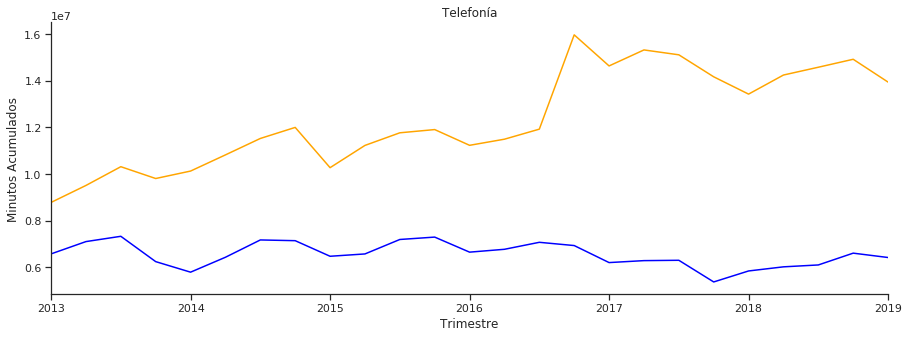

In [7]:
fig, ax= plt.subplots();#figsize=(9,6))
y_pospago.plot(color='orange')
y_prepago.plot(color='blue')
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos Acumulados')
ax.set_title('Telefonía')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [8]:
display(y_pospago.describe().round(2))
display(y_prepago.describe().round(2))

count          25.00
mean     12359295.44
std       2085582.33
min       8785943.00
25%      10821463.00
50%      11905073.00
75%      14240217.00
max      15960765.00
Name: pospago, dtype: float64

count         25.0
mean     6562909.4
std       516860.4
min      5380710.0
25%      6250549.0
50%      6579819.0
75%      7077838.0
max      7335154.0
Name: prepago, dtype: float64

## Random walk

In this section we use the random walk method to illustrate the process that we will follow to generate forecasts in the tutorials. 

1. Specify the forecast horizon.

2. Create a range of dates or periods starting from the time index following the last observation in the data. 

3. Generate the forecasts and store them in a series indexed by step 2. 

Below, we generate point forecasts for one to four quarters after the end of the series. 

In [9]:
h = 4
test_pospago=pd.period_range(start=y_pospago.index[-1]+1, periods=h, freq='Q')
pred_pospago=pd.Series(np.repeat(y_pospago.iloc[-1], h), index=test_pospago) # the forecast repeats the last observed values h times
pred_pospago

2019Q2    13937271
2019Q3    13937271
2019Q4    13937271
2020Q1    13937271
Freq: Q-DEC, dtype: int64

In [10]:
h = 4
test_prepago=pd.period_range(start=y_prepago.index[-1]+1, periods=h, freq='Q')
pred_prepago=pd.Series(np.repeat(y_prepago.iloc[-1], h), index=test_prepago) # the forecast repeats the last observed values h times
pred_prepago

2019Q2    6427084
2019Q3    6427084
2019Q4    6427084
2020Q1    6427084
Freq: Q-DEC, dtype: int64

In [11]:
resid_pospago = y_pospago-y_pospago.shift(1) # the shift lags the series by one period
sigma_pospago = resid_pospago.std()

resid_prepago = y_prepago-y_prepago.shift(1) # the shift lags the series by one period
sigma_prepago = resid_prepago.std()

print(round(sigma_pospago,3),round(sigma_prepago,3))


1111026.926 510832.977


In [12]:
intv_pospago = pd.concat([pred_pospago-stats.norm.ppf(0.975)*sigma_pospago*np.sqrt(np.arange(1,h+1)),
                   pred_pospago+stats.norm.ppf(0.975)*sigma_pospago*np.sqrt(np.arange(1,h+1))], axis=1)

intv_prepago = pd.concat([pred_prepago-stats.norm.ppf(0.975)*sigma_prepago*np.sqrt(np.arange(1,h+1)),
                   pred_prepago+stats.norm.ppf(0.975)*sigma_prepago*np.sqrt(np.arange(1,h+1))], axis=1)

display(intv_pospago.round(3))
display(intv_prepago.round(3))

,0,1
2019Q2,1.175970e+07,1.611484e+07
2019Q3,1.085772e+07,1.701682e+07
2019Q4,1.016560e+07,1.770894e+07
2020Q1,9.582125e+06,1.829242e+07


,0,1
2019Q2,5425869.763,7428298.237
2019Q3,5011153.247,7843014.753
2019Q4,4692930.072,8161237.928
2020Q1,4424655.526,8429512.474


In [13]:
y_pospago.index.min()

Period('2013Q1', 'Q-DEC')

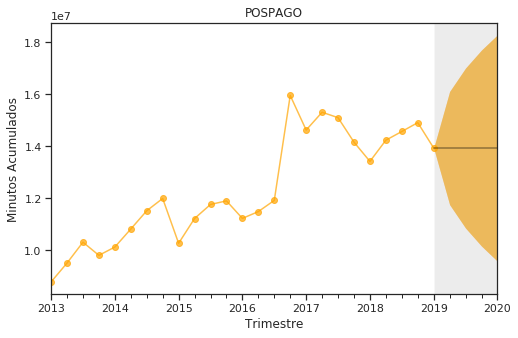

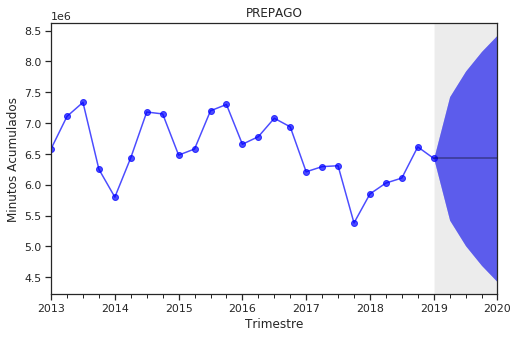

In [14]:
point_pred_pospago = (intv_pospago[0]+intv_pospago[1])/2
fig, ax = fanchart(y_pospago['2013':],point_pred_pospago,intv_pospago,intv_pospago,intv_pospago,'orange')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.ylabel('Minutos Acumulados')
plt.xlabel('Trimestre')
plt.title('POSPAGO')
point_pred_prepago = (intv_prepago[0]+intv_prepago[1])/2
ax.ticklabel_format(style='sci',axis='y')
fig, ax = fanchart(y_prepago['2013':],point_pred_prepago,intv_prepago,intv_prepago,intv_prepago,'blue')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
plt.ylabel('Minutos Acumulados')
plt.xlabel('Trimestre')
plt.title('PREPAGO')

plt.show()

## Simple exponential smoothing

The exponential smoothing functions are available since version 0.9 of statsmodels in the **tsa.
holtwinters** module. Take a look in the official [docs](https://www.statsmodels.org/stable/tsa.html#exponential-smoothing). Also, they are improving them, so follow the news for the next release.

In [15]:
model_pospago = sm.tsa.SimpleExpSmoothing(y_pospago).fit()
fitted_pospago = model_pospago.fittedvalues
model_pospago.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,28393933896676.352
Optimized:,True,AIC,697.958
Trend:,None,BIC,700.396
Seasonal:,None,AICC,699.958
Seasonal Periods:,None,Date:,"Tue, 01 Oct 2019"
Box-Cox:,False,Time:,00:10:02
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.7870587,alpha,True
initial_level,8.7859e+06,l.0,True


In [16]:
mse_pospago = sm.tools.eval_measures.mse(y_pospago,fitted_pospago)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_pospago))

 In-sample fit:
 MSE               1135757355867.054


In [17]:
N = len(y_pospago)
loglik_pospago=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_pospago)
aic_pospago=-2*loglik_pospago+2*3
bic_pospago=-2*loglik_pospago+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_pospago))
print(' AIC               {0:.3f}'.format(aic_pospago))
print(' BIC               {0:.3f}'.format(bic_pospago))

 Log-likelihood    -382.452
 AIC               770.905
 BIC               774.562


In [18]:
model_prepago = sm.tsa.SimpleExpSmoothing(y_prepago).fit()
fitted_prepago = model_prepago.fittedvalues
model_prepago.summary()

Dep. Variable:,endog,No. Observations:,25
Model:,SimpleExpSmoothing,SSE,5836570001516.250
Optimized:,True,AIC,658.407
Trend:,None,BIC,660.845
Seasonal:,None,AICC,660.407
Seasonal Periods:,None,Date:,"Tue, 01 Oct 2019"
Box-Cox:,False,Time:,00:10:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4341128,alpha,True
initial_level,6.6993e+06,l.0,True


In [19]:
mse_prepago = sm.tools.eval_measures.mse(y_prepago,fitted_prepago)
print(' In-sample fit:')
print(' MSE               {0:.3f}'.format(mse_prepago))

 In-sample fit:
 MSE               233462800060.650


In [20]:
N = len(y_prepago)
loglik_prepago=-(N/2)*(1+np.log(2*np.pi))-(N/2)*np.log(mse_prepago)
aic_prepago=-2*loglik_prepago+2*3
bic_prepago=-2*loglik_prepago+np.log(N)*3
print(' Log-likelihood    %.3f' % (loglik_prepago))
print(' AIC               {0:.3f}'.format(aic_prepago))
print(' BIC               {0:.3f}'.format(bic_prepago))

 Log-likelihood    -362.677
 AIC               731.354
 BIC               735.011


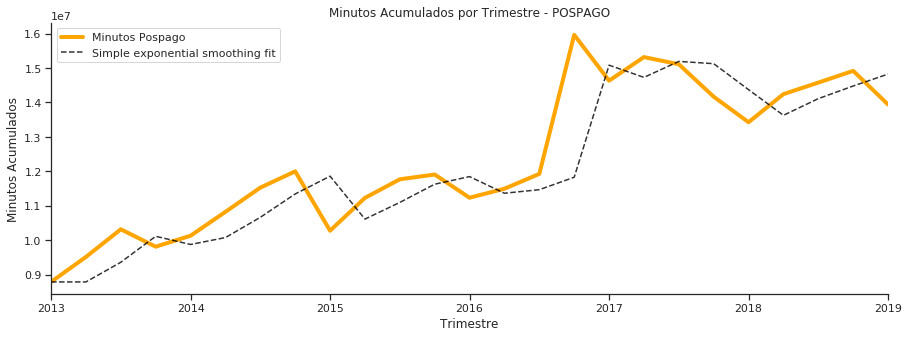

In [21]:
fig, ax= plt.subplots();#figsize=(9,6))
y_pospago.plot(color='orange', label='Minutos Pospago', lw=4)
fitted_pospago.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8,ls='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos Acumulados')
ax.set_title('Minutos Acumulados por Trimestre - POSPAGO')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

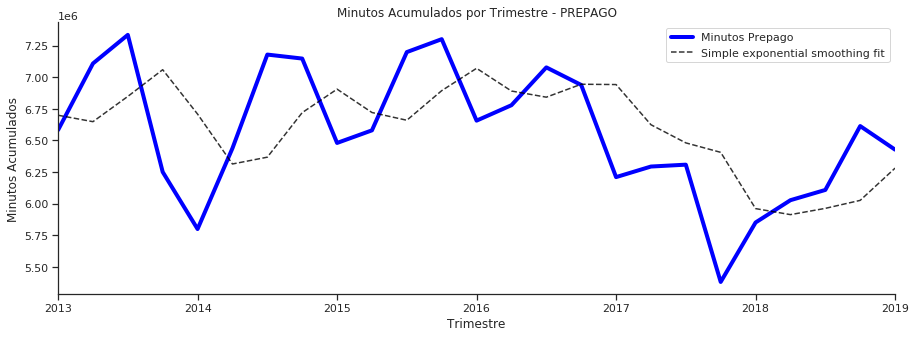

In [22]:
fig, ax= plt.subplots();#figsize=(9,6))
y_prepago.plot(color='blue', label='Minutos Prepago', lw=4)
fitted_prepago.plot(color='black', label='Simple exponential smoothing fit', alpha=0.8,ls='--')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-2, 2))
ax.set_xlabel('Trimestre')
ax.set_ylabel('Minutos Acumulados')
ax.set_title('Minutos Acumulados por Trimestre - PREPAGO')
ax.set_xticks([], minor=True) 
plt.legend(loc='best')
sns.despine()
plt.show()

## Model diagnostics

We now conduct residual diagnostics for the exponential smoothing. Recall from the lectures that the key diagnostics for univariate time series are: 

1. Residual plot.
2. Residual autocorrelation function (ACF) plot.
3. Residual distribution plots.

We compute the residuals as follows.

In [0]:
resid_pospago=y_pospago-fitted_pospago # model_ses.resid isn't a panda.Series, so no index, no plot
resid_prepago=y_prepago-fitted_prepago 

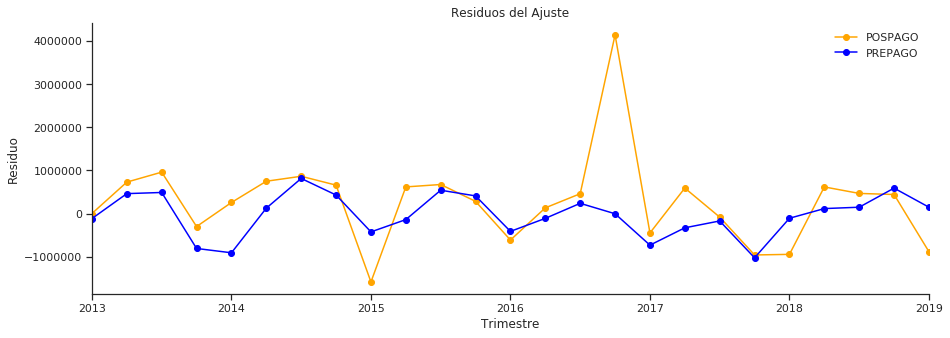

In [24]:
fig, ax= plt.subplots();#figsize=(9,6))
resid_pospago.plot(color='orange',marker='o',label='POSPAGO')
resid_prepago.plot(color='blue',marker='o',label='PREPAGO')
ax.set_xlabel('Trimestre')
ax.set_ylabel('Residuo')
ax.set_xticks([], minor=True) 
ax.set_title('Residuos del Ajuste')
plt.legend(frameon=False)
sns.despine()
plt.show()

### SE EVIDENCIA UNA ESTACIONALIDAD, AÚN MÁS CLARA EN LOS DATOS DE TELEFONÍA PREPAGA

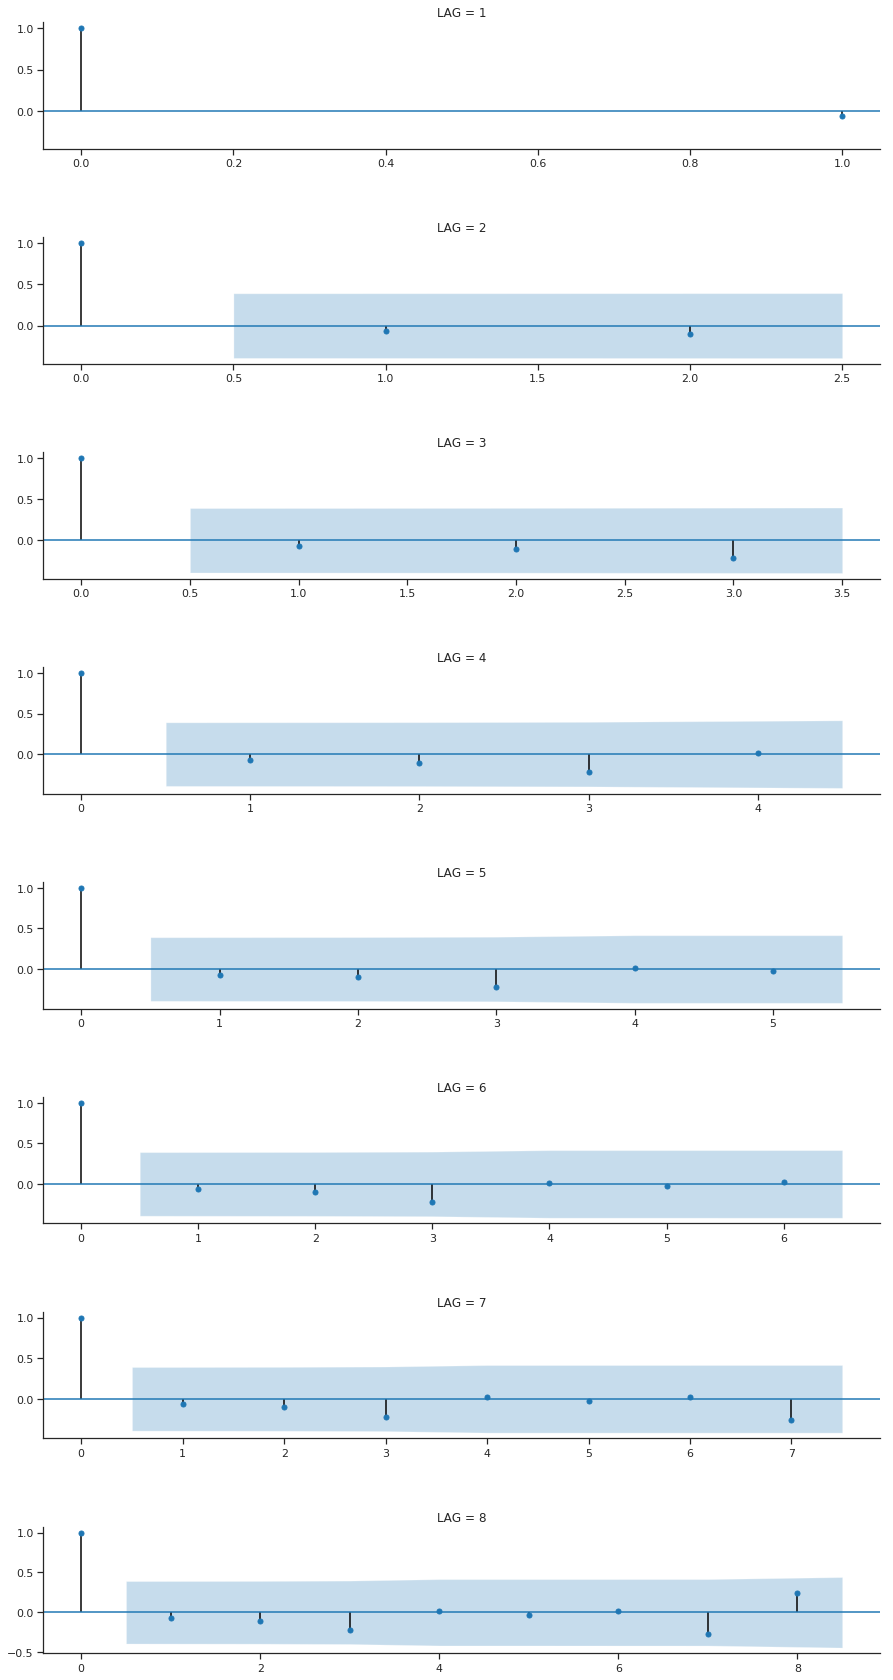

In [25]:
plt.figure(figsize=(15,30))
for i,lag in enumerate([1,2,3,4,5,6,7,8]):
    ax = plt.subplot(8,1,i+1)
    sm.graphics.tsa.plot_acf(resid_pospago, lags=lag , ax=ax)
    plt.title('LAG = '+str(lag))
    sns.despine()
    
plt.subplots_adjust(hspace=0.7)
plt.show()

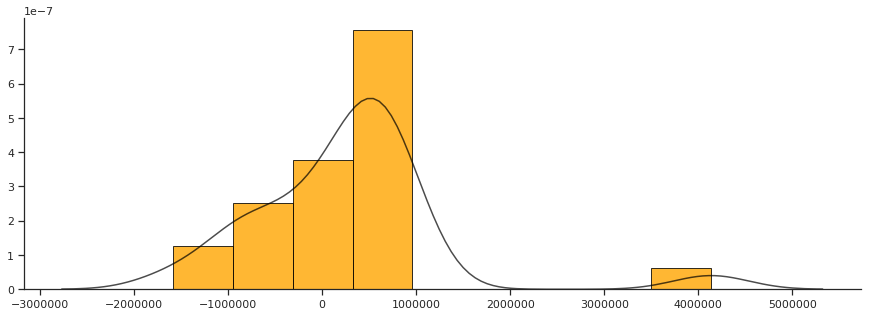

In [26]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': 'orange'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid_pospago)
plt.show()

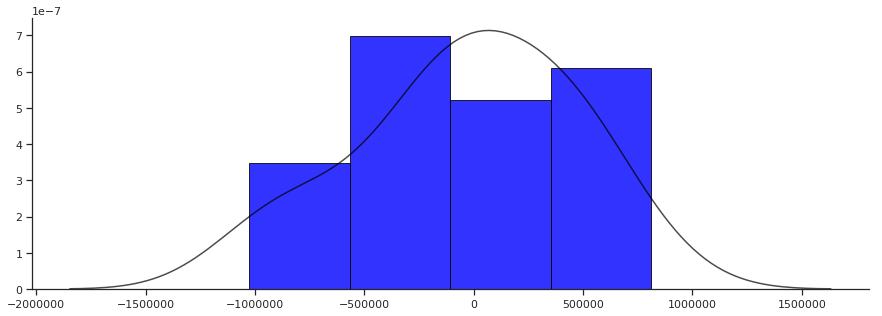

In [27]:
def hist(series):
    fig, ax= plt.subplots();#figsize=(9,6))
    sns.distplot(series, ax=ax, hist_kws={'alpha': 0.8, 'edgecolor':'black', 'color': 'blue'},  
                 kde_kws={'color': 'black', 'alpha': 0.7})
    sns.despine()
    return fig, ax

hist(resid_prepago)
plt.show()

### EN NINGÚN CASO SE OBSERVA UNA DISTRIBUCIÓN NORMAL DE LOS RESIDUOS 


In [28]:
y_pospago.index.min(),y_pospago.index.max()

(Period('2013Q1', 'Q-DEC'), Period('2019Q1', 'Q-DEC'))

## Model validation

We implement a real time forecasting exercise to compare the random walk and simple exponential smoothing methods. 

In [29]:
# Real time forecasting - use it as a template - expanding window

validation=y_pospago['2016Q1':].index # the validation period is Q1 2004 onwards
start = y_pospago.index.get_loc('2016Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_pospago)):
    actual.append(y_pospago.iloc[i]) # actual value
    pred1.append(y_pospago.iloc[i-1]) # random walk forecast
    model = sm.tsa.SimpleExpSmoothing(y_pospago.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

,RW,SES,Actual
quarter,,,
2018Q1,14164552.0,1.437147e+07,13423580.0
2018Q2,13423580.0,1.359029e+07,14240217.0
2018Q3,14240217.0,1.411031e+07,14574305.0
2018Q4,14574305.0,1.448080e+07,14915060.0
2019Q1,14915060.0,1.482888e+07,13937271.0


In [30]:
from scipy import stats

table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,1317870.366,377750.518
SES,1345972.155,385880.951


## Forecast

We show how to do expanding and rolling point forecast. 

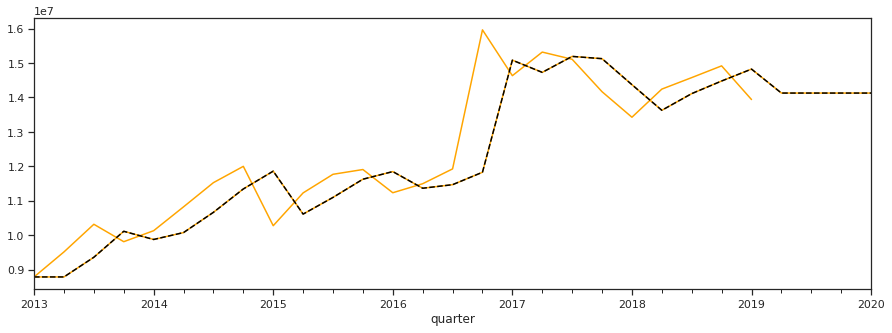

In [31]:
h=4
w=h*10
data = y_pospago
model = sm.tsa.SimpleExpSmoothing
pred_index = y_pospago.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='orange');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='orange');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='black',ls='--');

In [32]:
# Real time forecasting - use it as a template - expanding window

validation=y_prepago['2016Q1':].index # the validation period is Q1 2004 onwards
start = y_prepago.index.get_loc('2016Q1') # numerical index corresponding to Q1 2005

pred1 = []
pred2 = []
actual= []
for i in range(start, len(y_prepago)):
    actual.append(y_prepago.iloc[i]) # actual value
    pred1.append(y_prepago.iloc[i-1]) # random walk forecast
    model = sm.tsa.SimpleExpSmoothing(y_prepago.iloc[:i]).fit() 
    pred2.append(model.forecast(1)[0]) # SES forecast

columns=['RW', 'SES', 'Actual']
results_sm = np.vstack([pred1,pred2,actual]).T
results_sm = pd.DataFrame(results_sm, columns=columns, index=validation)
results_sm.tail()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


,RW,SES,Actual
quarter,,,
2018Q1,5380710.0,6.652112e+06,5850985.0
2018Q2,5850985.0,5.888787e+06,6027374.0
2018Q3,6027374.0,5.961229e+06,6108477.0
2018Q4,6108477.0,6.026748e+06,6613685.0
2019Q1,6613685.0,6.265480e+06,6427084.0


In [33]:
table = pd.DataFrame(0.0, index=results_sm.columns[:-1], columns=['RMSE','SE'])
for i in range(2):
    table.iloc[i,0] = sm.tools.eval_measures.rmse(results_sm.iloc[:,i], results_sm.iloc[:,-1])
    table.iloc[i,1] = (results_sm.iloc[:,i] - results_sm.iloc[:,-1]).sem()
table.round(3)

,RMSE,SE
RW,437377.897,124759.740
SES,536273.070,146322.955


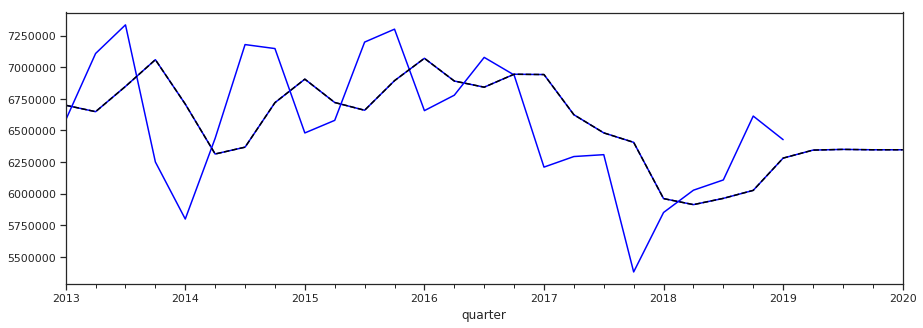

In [34]:
h=4
w=h*10
data = y_prepago
model = sm.tsa.SimpleExpSmoothing
pred_index = y_prepago.index[-1] + np.array(range(1,h+1))
pred_rolling = pd.Series(0,index=pred_index)
pred_expanding = pd.Series(0,index=pred_index)
orig_exp = None
orig_roll = None
for i in range(0,h):
    current_exp = pd.concat([data, pred_expanding.head(i)])
    expanding = model(current_exp).fit()
    pred_expanding.update(expanding.forecast(1))
    current_roll = pd.concat([data, pred_rolling.head(i)])
    rolling = model(current_roll.tail(w)).fit()
    pred_rolling.update(rolling.forecast(1))
    if i==0:
        orig_fit = expanding.fittedvalues
        orig_roll = rolling.fittedvalues
ax = data[-w:].plot(color='blue');#figsize=(9,6))
pd.concat([orig_fit[-w:],pred_expanding]).plot(ax=ax,color='blue');
pd.concat([orig_roll[-w:],pred_rolling]).plot(ax=ax,color='black',ls='--');

### ES EVIDENTE QUE LOS MODELOS UTILIZADOS NO SON BUENOS PARA HACER PREDICCIONES